## COVID Detection using Chest X-Rays

<img src="covid_banner.png">

### Introduction
Coronavirus disease 2019 (COVID-19), also known as the coronavirus or COVID, is a contagious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The first known case was identified in Wuhan, China, in December 2019. The disease has since spread worldwide, leading to an ongoing pandemic. Symptoms of COVID-19 are variable, but often include fever, cough, headache, fatigue, breathing difficulties, and loss of smell and taste. Symptoms may begin one to fourteen days after exposure to the virus. At least a third of people who are infected do not develop noticeable symptoms.

### Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (COVID/Normal).

This COVID-19 dataset is released in stages. In the first release, they released 219 COVID-19, 1341 normal chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal. We will continue to update this database as soon as we have new X-Ray images for COVID-19 pneumonia patients.

### Importing Libraries

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzipping

In [3]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/x_rays.zip')

### Setting the paths

In [4]:
labels = ['COVID', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_training_data('x_rays/train')
test = get_training_data('x_rays/test')
val = get_training_data('x_rays/val')

### Exploratory Data Analysis

In [6]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3616
Normal: 10192
Pneumonia - Normal: -6576


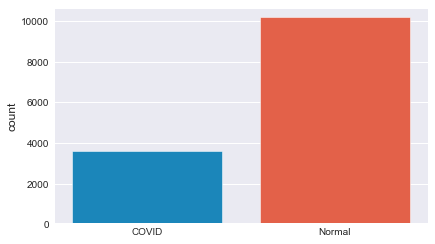

In [7]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("COVID")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

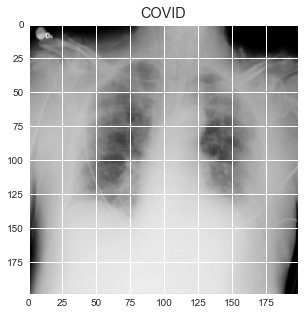

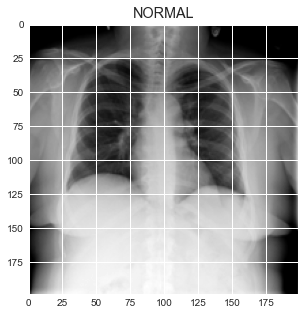

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

### Resizing the images

In [8]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [9]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

### Balancing the dataset

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

### Building the model

In [11]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 256)     2560      
_________________________________________________________________
activation (Activation)      (None, 200, 200, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 256)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 256)     1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      147520    
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0

### Compiling the model

In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks = [early_stop], validation_data = (X_val, y_val), epochs = 20)

Epoch 1/20
961/961 [==============================] - 162s 136ms/step - loss: 0.7125 - acc: 0.6690 - val_loss: 0.4833 - val_acc: 0.7689
Epoch 2/20
961/961 [==============================] - 127s 132ms/step - loss: 0.5259 - acc: 0.7335 - val_loss: 0.4410 - val_acc: 0.8006
Epoch 3/20
961/961 [==============================] - 126s 132ms/step - loss: 0.4877 - acc: 0.7513 - val_loss: 0.4711 - val_acc: 0.7852
Epoch 4/20
961/961 [==============================] - 126s 131ms/step - loss: 0.4811 - acc: 0.7601 - val_loss: 0.3910 - val_acc: 0.8226
Epoch 5/20
961/961 [==============================] - 126s 131ms/step - loss: 0.4817 - acc: 0.7609 - val_loss: 0.3831 - val_acc: 0.8276
Epoch 6/20
961/961 [==============================] - 126s 131ms/step - loss: 0.4513 - acc: 0.7814 - val_loss: 0.4164 - val_acc: 0.8052
Epoch 7/20
961/961 [==============================] - 126s 131ms/step - loss: 0.4332 - acc: 0.7844 - val_loss: 0.8749 - val_acc: 0.7465
Epoch 8/20
961/961 [============================

### Evaluating the test dataset

In [13]:
model.evaluate(X_test, y_test)

94/94 [==============================] - 15s 160ms/step - loss: 0.3973 - acc: 0.8141


[0.39726945757865906, 0.8141239285469055]

### Saving the main model

In [14]:
model.save('covid_detection_model.h5')

### Plotting the Accuracy

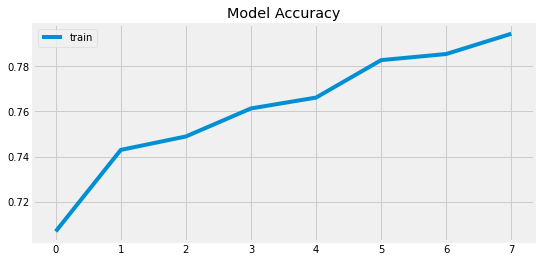

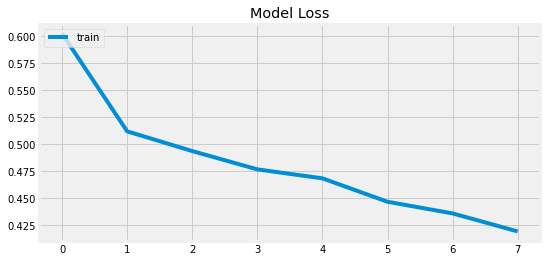

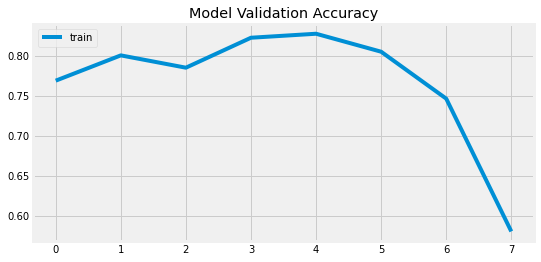

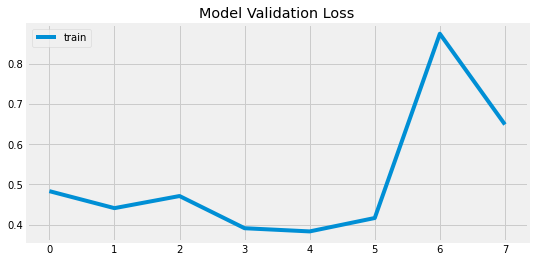

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

### Plotting Precision vs Recall

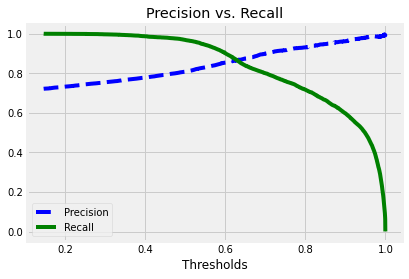

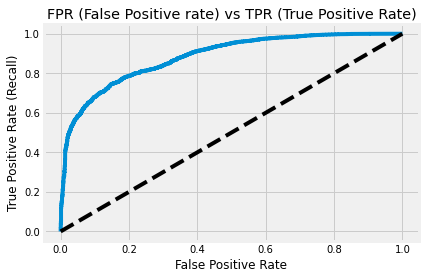

In [16]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [17]:
predictions = model.predict(X_test)

In [18]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

### Plotting Confusion Matrix

[Text(0, 0.5, 'COVID'), Text(0, 1.5, 'NORMAL')]

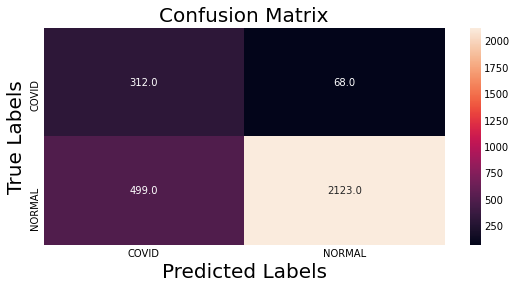

In [22]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(8, 4))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt=".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

### Testing of the images

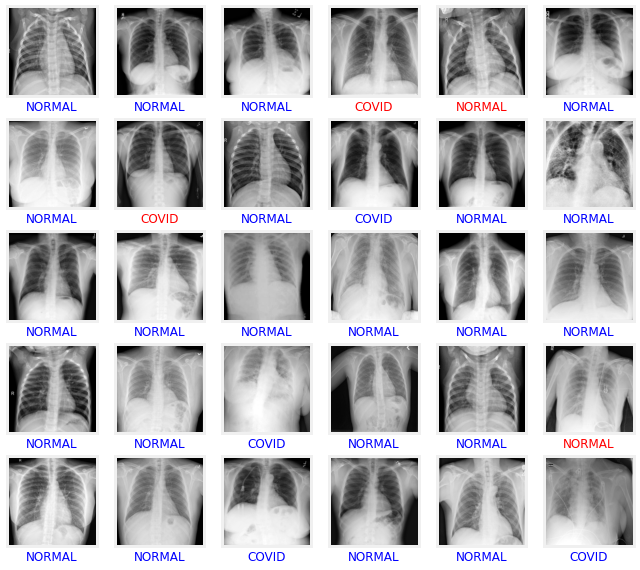

In [31]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()